In [1]:
import numpy as np
import wormholes as wh
import matplotlib.pyplot as plt
from matplotlib import colors, patches
from tqdm.notebook import tqdm
import colorcet as cc

In [2]:
# Suppress warnings
# (Many overflows/underflows otherwise, since exp(u,v,φ) appear throughout)
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{amssymb} \\usepackage{amsmath}'

### Massive type IIA on $S^3\times S^3$

Scanning over the parameters ($u_0,\phi_0$) shows which values are potentially viable for fixed $q_0$:

100%|██████████| 900/900 [00:13<00:00, 66.08it/s] 


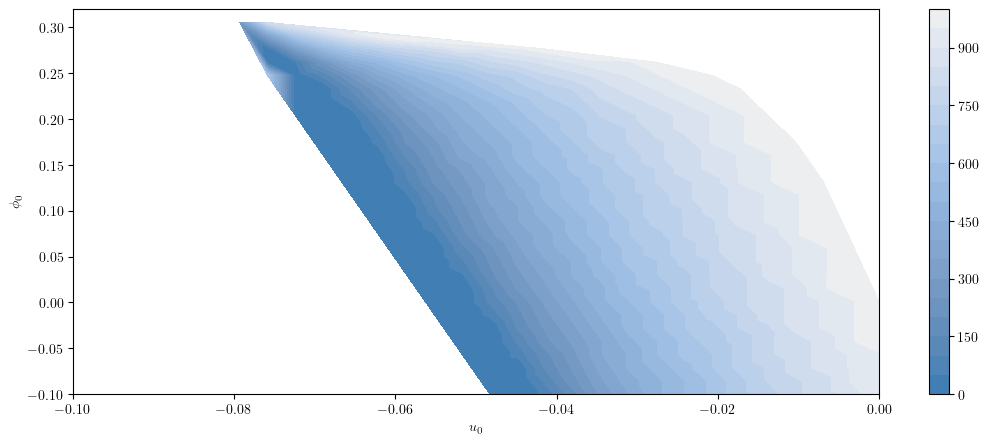

In [107]:
wh.paramScan_S3S3(1, 10, [-0.1, 0], [-0.1, 0.32], 30, 30)

Example profiles upon picking ($u_0,\phi_0$) by hand:

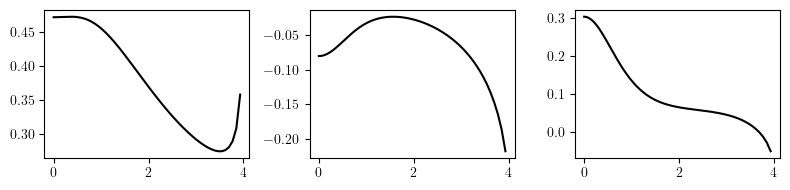

In [109]:
q0, rmax = 1, 10
u0, φ0 = -0.0802, 0.304
soln = wh.solve_S3S3(q0, rmax, u0, φ0)
r, f, u, ud, φ, φd, h, f4sqr = soln

fig, axes = plt.subplots(1, 3, figsize=(8,2))

axes[0].plot(r, f, 'k')
axes[1].plot(r, u, 'k')
axes[2].plot(r, φ, 'k')

plt.tight_layout()
plt.show()

The optimal solution matching AdS boundary conditions is found using a shooting method. The end-point of the integration is increased in steps up to rmax (using lower precision along the way).


Performing shooting method for q0 = 1 out to r = 10 ...
    rmax = 1.0000 with xatol = 0.0001
        f_eval : 98
            u0 : -0.07570750404
            φ0 : +0.2679907332
           val : 1.07982886e-08
    rmax = 3.1623 with xatol = 0.0001
        f_eval : 47
            u0 : -0.07891023104
            φ0 : +0.2942145175
           val : 5.982180773e-08
    rmax = 10.0000 with xatol = 1e-10
        f_eval : 137
            u0 : -0.07891872148
            φ0 : +0.2943215978
           val : 0


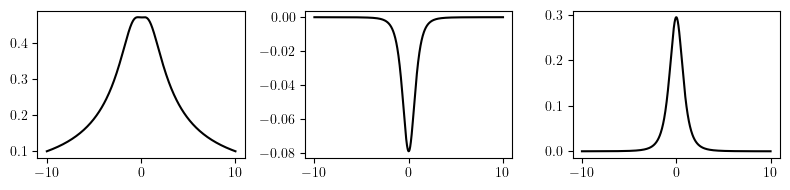

In [147]:
q0, rmax = 1, 10
soln = wh.wormhole_S3S3(q0, rmax, xatol=10**-10)
r, f, u, ud, φ, φd, h, f4sqr = soln

fig, axes = plt.subplots(1, 3, figsize=(8,2), sharex=True)

axes[0].plot(r, f, 'k')
axes[1].plot(r, u, 'k')
axes[2].plot(r, φ, 'k')

plt.tight_layout()
plt.show()

More detailed plot of profiles:

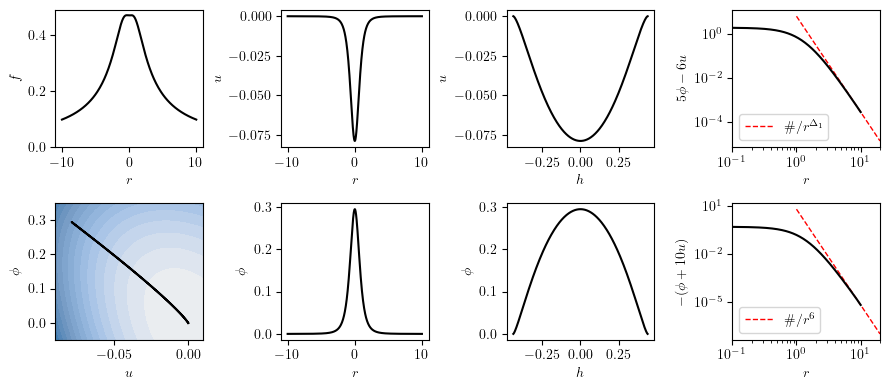

In [112]:
fig, axes = plt.subplots(2, 4, figsize=(9,4))

q = wh.Q(r, q0)

xdata = [r, r, h, r, u, r, h, r]
ydata = [f, u, u, 5*φ-6*u, φ, φ, φ, -(φ+10*u)]
xlabels = ['$r$', '$r$', '$h$', '$r$', '$u$', '$r$', '$h$', '$r$']
ylabels = ['$f$', '$u$', '$u$', '$5\phi-6u$', '$\phi$', '$\phi$', '$\phi$', '$-(\phi+10u)$']


# Plot expected power-law fall-offs in asymptotic region
Δ1 = (3+np.sqrt(33))/2
fcoeff = np.mean(r[-10:]**2 * (f[-10:]**(-2) - (r[-10:]**2 + (1+2*q0**2))))
uφcoeff1 = np.mean(r[-10:]**Δ1 * (5*φ[-10:] - 6*u[-10:]))
uφcoeff2 = np.mean(r[-10:]**6 * (-φ[-10:] - 10*u[-10:]))

rr = np.linspace(q0, 2*rmax, 2)
axes[0,3].plot(rr, uφcoeff1/rr**Δ1, '--r', lw=1, label='$\#/r^{\Delta_1}$')
axes[1,3].plot(rr, uφcoeff2/rr**6, '--r', lw=1, label='$\#/r^6$')

# Plot grid of xy-data
for ax, xx, yy, xlab, ylab in zip(axes.ravel(), xdata, ydata, xlabels, ylabels):
    ax.plot(xx, yy, 'k')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

# for ax in axes[0]:
#     ax.set_xlim(-10, 10)
axes[0,0].set_ylim(0)

# Superimpose potential in u-φ plot
u0s = np.linspace(-0.09, 0.01, 40)
φ0s = np.linspace(-0.05, 0.35, 40)
umesh, φmesh = np.meshgrid(u0s, φ0s)
VV = wh.V_S3S3(umesh, φmesh)

axes[1,0].contourf(umesh, φmesh, VV,
                   levels=np.arange(-6, -4.4, 0.1),
                   cmap=cc.cm['CET_L12'],
                   extent=(u0s[0], u0s[-1], φ0s[0], φ0s[-1])
                  )

axes[1,0].set_xlim(u0s[0], u0s[-1])
axes[1,0].set_ylim(φ0s[0], φ0s[-1])


for ax in axes[:,3]:
    ax.set_xlim(0.1*q0, 2*rmax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.tight_layout()

# plt.savefig('images/S3S3_profile_example.png', dpi=300)
plt.show()

Field ranges (with comparison to _ad hoc_ replacement $\mathcal{V}\to-6$ where $u,\phi$ are massless):

In [149]:
q0s = np.geomspace(0.0001, 10, 20)

q0s_ml = np.geomspace(q0s[0], q0s[-1], 20)
data_ml = np.asarray([wh.massless_approx_S3S3(q0) for q0 in q0s_ml])
u0s_ml, φ0s_ml, f4s_ml = data_ml.T

data = []

for q0 in q0s:

    rmax = max(10, 10*q0)
    soln = wh.wormhole_S3S3(q0, rmax, xatol=10**-8)
    r, f, u, ud, φ, φd, h, f4sqr = soln

    # It happens that u<0 and φ>0
    data.append([min(u), max(φ), np.sqrt(f4sqr)])

u0s, φ0s, f4s = np.asarray(data).T


Performing shooting method for q0 = 0.0001 out to r = 10 ...
    rmax = 0.0001 with xatol = 0.0001
        f_eval : 118
            u0 : -0.2993062535
            φ0 : +0.6303910603
           val : 9.261458267e-10
    rmax = 0.0316 with xatol = 0.0001
        f_eval : 79
            u0 : -0.782941184
            φ0 : +1.565915033
           val : 1.440308761e-09
    rmax = 10.0000 with xatol = 1e-08
        f_eval : 118
            u0 : -0.7829423009
            φ0 : +1.565899692
           val : 1.532107774e-14

Performing shooting method for q0 = 0.00018329807108324357 out to r = 10 ...
    rmax = 0.0002 with xatol = 0.0001
        f_eval : 118
            u0 : -0.2993062535
            φ0 : +0.6303910603
           val : 9.251988065e-10
    rmax = 0.0428 with xatol = 0.0001
        f_eval : 80
            u0 : -0.7829105945
            φ0 : +1.565812434
           val : 8.97369512e-10
    rmax = 10.0000 with xatol = 1e-08
        f_eval : 116
            u0 : -0.7829072972
       

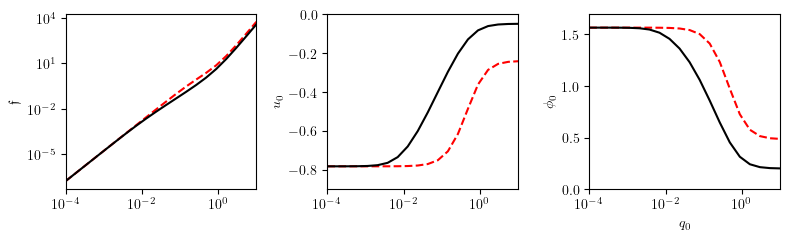

In [151]:
fig, axes = plt.subplots(1, 3, figsize=(8,2.5), sharex=True)

axes[0].plot(q0s_ml, f4s_ml, '--r')
axes[0].plot(q0s, f4s, 'k', ms=3)
axes[0].set_yscale('log')
axes[0].set_ylabel('$\mathfrak{f}$')

axes[1].plot(q0s_ml, u0s_ml, '--r')
axes[1].plot(q0s, u0s, 'k', ms=3)
axes[1].set_ylabel('$u_0$')
axes[1].set_ylim(-0.9, 0)

axes[2].plot(q0s_ml, φ0s_ml, '--r')
axes[2].plot(q0s, φ0s, 'k', ms=3)
axes[2].set_ylabel('$\phi_0$')
axes[2].set_ylim(0, 1.7)

plt.xlim(q0s[0], q0s[-1])
plt.xscale('log')
plt.xlabel('$q_0$')

plt.tight_layout()
# plt.savefig('images/S3S3_ranges.png', dpi=300)
plt.show()

Flat-space limit


Performing shooting method for q0 = 1.0 out to r = 100 ...
    rmax = 1.0000 with xatol = 0.0001
        f_eval : 98
            u0 : -0.07570750404
            φ0 : +0.2679907332
           val : 1.07982886e-08
    rmax = 10.0000 with xatol = 0.0001
        f_eval : 75
            u0 : -0.07891541747
            φ0 : +0.2942800927
           val : 3.808220613e-06
    rmax = 100.0000 with xatol = 1e-12
        f_eval : 192
            u0 : -0.07891872314
            φ0 : +0.2943216216
           val : 6.661338148e-16

Performing shooting method for q0 = 0.1 out to r = 100 ...
    rmax = 0.1000 with xatol = 0.0001
        f_eval : 113
            u0 : -0.2595244827
            φ0 : +0.6021362378
           val : 1.69582659e-09
    rmax = 3.1623 with xatol = 0.0001
        f_eval : 92
            u0 : -0.359341949
            φ0 : +0.9822359592
           val : 2.120974448e-07
    rmax = 100.0000 with xatol = 1e-12
        f_eval : 213
            u0 : -0.3593439707
            φ0 : +0.

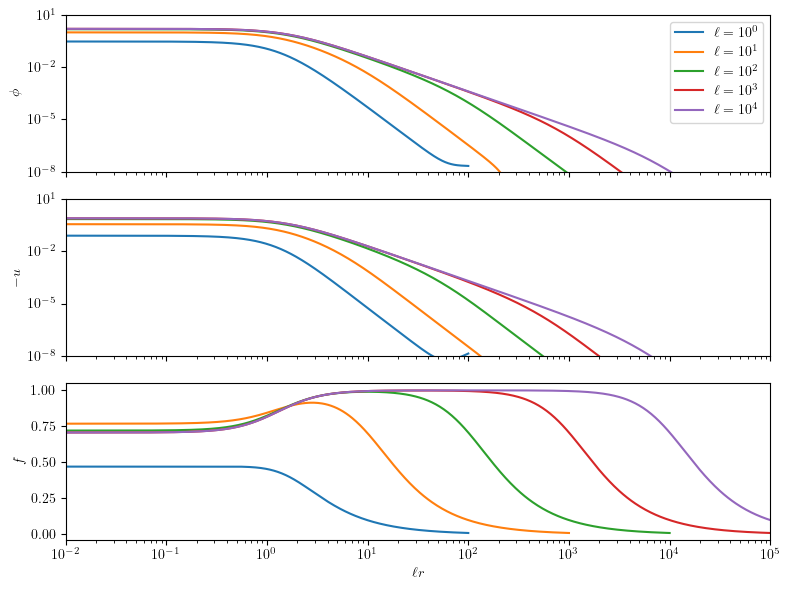

In [105]:
a0 = 1
powers = [0, 1, 2, 3, 4]

fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True)

for power in powers:
    l = 10**power
    q0 = a0 / l
    
    rmax = 100
    soln = wh.wormhole_S3S3(q0, rmax, xatol=10**-12)
    r, f, u, ud, φ, φd, h, f4sqr = soln

    q = wh.Q(r, q0)

    axes[0].plot(l*r, φ, label='$\ell=10^{}$'.format(power))
    axes[1].plot(l*r, -u)
    axes[2].plot(l*r, f)

plt.xlim(10**-2, 10**5)
plt.xscale('log')
plt.xlabel('$\ell r$')

axes[0].set_ylim(10**-8, 10)
axes[0].set_yscale('log')
axes[0].set_ylabel('$\phi$')
axes[0].legend()

axes[1].set_ylim(10**-8, 10)
axes[1].set_yscale('log')
axes[1].set_ylabel('$-u$')

axes[2].set_ylabel('$f$')

plt.tight_layout()
plt.savefig('images/S3S3_flat_limit.png', dpi=300)
plt.show()

### Type IIB on $T^{1,1}$

Scanning over the parameters ($u_0,v_0$) shows which values are potentially viable for fixed $q_0$ and $\chi_0'$:

100%|██████████| 400/400 [01:06<00:00,  6.04it/s]


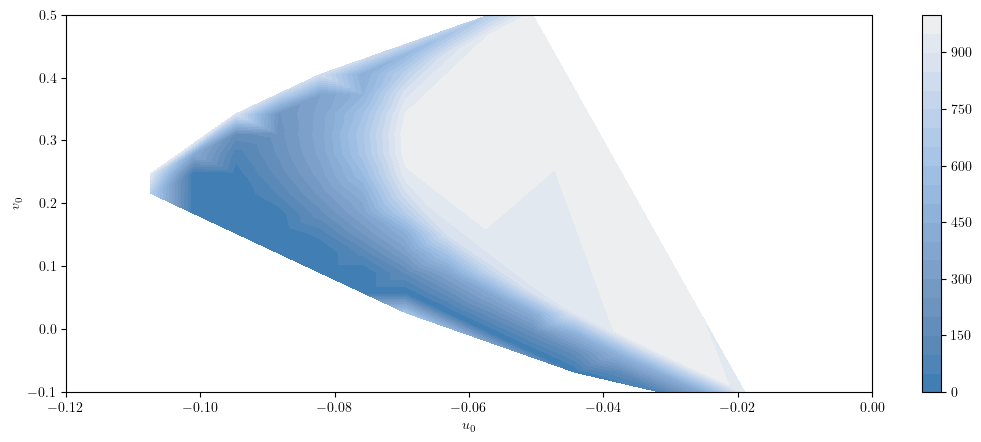

In [152]:
wh.paramScan_T11(1, 0, [-0.12, 0], [-0.1, 0.5], 20, 20, 5)

The optimal solution matching AdS boundary conditions is found using a shooting method. The end-point of the integration is increased in steps up to rmax (using lower precision along the way).


Performing shooting method for q0 = 1 and χ0p = 0.1 out to r = 10 ...
    rmax = 1.0000 with xatol = 0.0001
        f_eval : 103
            u0 : -0.09943698196
            v0 : +0.1694211585
           val : 1.856371723e-09
    rmax = 3.1623 with xatol = 0.0001
        f_eval : 51
            u0 : -0.1028827965
            v0 : +0.1823549146
           val : 1.756943246e-07
    rmax = 10.0000 with xatol = 1e-12
        f_eval : 281
            u0 : -0.102889147
            v0 : +0.1823857261
           val : 0


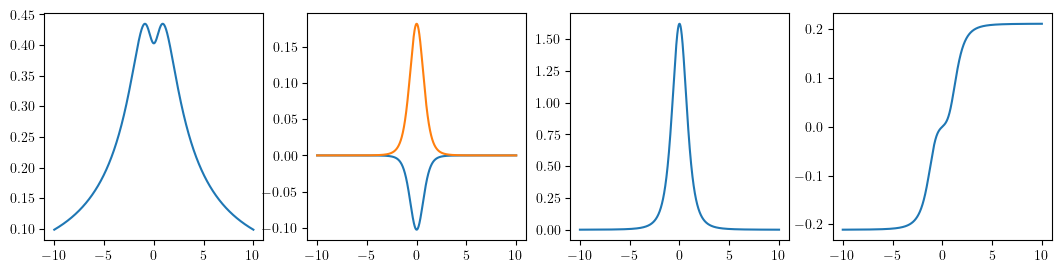

In [153]:
q0 = 1
χ0p = 0.1
rmax = 10
soln = wh.wormhole_T11(q0, χ0p, rmax, xatol=10**-12)
r, f, u, ud, v, vd, φ, φd, χ, χd, h, flux2 = soln

fig, axes = plt.subplots(1, 4, figsize=(13,3))

axes[0].plot(r, f)
axes[1].plot(r, u)
axes[1].plot(r, v)
axes[2].plot(r, φ)
axes[3].plot(r, χ)

plt.show()

More detailed plot of profiles:

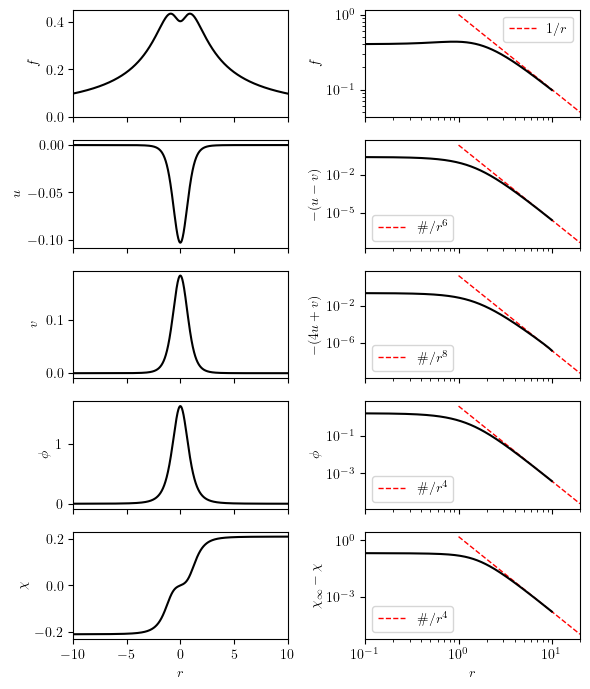

In [155]:
fig, axes = plt.subplots(5, 2, figsize=(6,7), sharex='col')

χinf = χ[-1] + r[-1]*χd[-1]/4

ydata = [f, f, u, -(u-v), v, -(4*u+v), φ, φ, χ, χinf - χ]
ylabels = ['$f$', '$f$', '$u$', '$-(u-v)$', '$v$', '$-(4u+v)$', '$\phi$', '$\phi$', '$\chi$', '$\chi_\infty-\chi$']


# Plot expected power-law fall-offs in asymptotic region
uvcoeff1 = np.mean(r[-10:]**6 * (-u[-10:] + v[-10:]))
uvcoeff2 = np.mean(r[-10:]**8 * (-4*u[-10:] - v[-10:]))
φcoeff = np.mean(r[-10:]**4 * φ[-10:])
χcoeff = np.mean(r[-10:]**4 * (χinf - χ[-10:]))

rr = np.linspace(q0, 2*rmax, 2)
axes[0,1].plot(rr, 1/rr, '--r', lw=1, label='$1/r$')
axes[1,1].plot(rr, uvcoeff1/rr**6, '--r', lw=1, label='$\#/r^6$')
axes[2,1].plot(rr, uvcoeff2/rr**8, '--r', lw=1, label='$\#/r^8$')
axes[3,1].plot(rr, φcoeff/rr**4, '--r', lw=1, label='$\#/r^4$')
axes[4,1].plot(rr, χcoeff/rr**4, '--r', lw=1, label='$\#/r^4$')

# Plot grid of xy-data
for ax, yy, ylab in zip(axes.ravel(), ydata, ylabels):
    ax.plot(r, yy, 'k')
    ax.set_ylabel(ylab)

axes[0,0].set_ylim(0)

for ax in axes[:,1]:
    ax.set_yscale('log')
    ax.legend()


axes[0,0].set_xlim(-10, 10)
axes[4,1].set_xlim(0.1*q0, 2*rmax)
axes[4,1].set_xscale('log')
axes[4,0].set_xlabel('$r$')
axes[4,1].set_xlabel('$r$')

plt.tight_layout()
plt.savefig('images/T11_profiles_ex1.png', dpi=300)
plt.show()

Profiles as $\chi_0'$ is adjusted:


Performing shooting method for q0 = 0.1 and χ0p = 0 out to r = 10 ...
    rmax = 0.1000 with xatol = 0.0001
        f_eval : 112
            u0 : -0.3745292062
            v0 : +0.4563188723
           val : 1.644733683e-09
    rmax = 1.0000 with xatol = 0.0001
        f_eval : 122
            u0 : -0.4585074144
            v0 : +0.6698583039
           val : 3.208080771e-07
    rmax = 10.0000 with xatol = 1e-12
        f_eval : 294
            u0 : -0.4585076441
            v0 : +0.6698754635
           val : 0

Performing shooting method for q0 = 0.1 and χ0p = 0.2 out to r = 10 ...
    rmax = 0.1000 with xatol = 0.0001
        f_eval : 110
            u0 : -0.3744979663
            v0 : +0.4562568116
           val : 7.768670152e-10
    rmax = 1.0000 with xatol = 0.0001
        f_eval : 104
            u0 : -0.4584888732
            v0 : +0.6698246405
           val : 3.042058967e-07
    rmax = 10.0000 with xatol = 1e-12
        f_eval : 383
            u0 : -0.4584904709
          

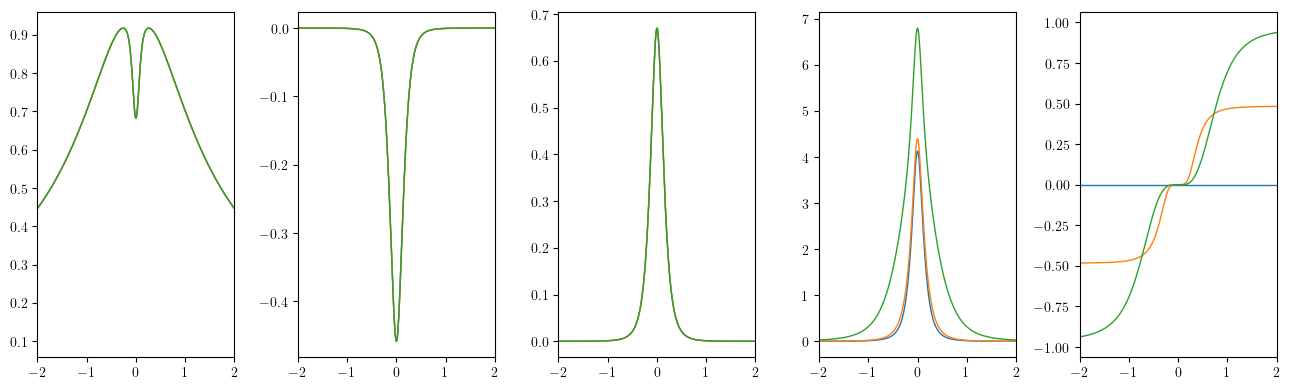

In [220]:
q0 = 0.1
rmax = 10

χ0p_list = [0, 0.2, 0.4]


fig, axes = plt.subplots(1, 5, figsize=(13,4), sharex=True)


for χ0p in χ0p_list:
    soln = wh.wormhole_T11(q0, χ0p, rmax, xatol=10**-12)
    r, f, u, ud, v, vd, φ, φd, χ, χd, h, flux2 = soln

    axes[0].plot(r, f, lw=1)
    axes[1].plot(r, u, lw=1)
    axes[2].plot(r, v, lw=1)
    axes[3].plot(r, φ, lw=1)
    axes[4].plot(r, χ, lw=1)

plt.xlim(-2, 2)

plt.tight_layout()
plt.show()

Fixed $\chi_0'=0$:

In [190]:
q0_list = np.geomspace(0.2, 5, 10)

flux2_data = []
urange_data = []
vrange_data = []
φrange_data = []

for q0 in q0_list:

    rmax = 10

    soln = wh.wormhole_T11(q0, 0, rmax, xatol=10**-10)
    r, f, u, ud, v, vd, φ, φd, χ, χd, h, flux2 = soln

    flux2_data.append(flux2)
    urange_data.append(max(u) - min(u))
    vrange_data.append(max(v) - min(v))
    φrange_data.append(max(φ) - min(φ))


Performing shooting method for q0 = 0.20000000000000004 and χ0p = 0.04999999999999999 out to r = 10 ...
    rmax = 0.2000 with xatol = 0.0001
        f_eval : 110
            u0 : -0.2759073016
            v0 : +0.3745957357
           val : 5.477578391e-09
    rmax = 1.4142 with xatol = 0.0001
        f_eval : 78
            u0 : -0.3135287476
            v0 : +0.4889664766
           val : 2.47997791e-07
    rmax = 10.0000 with xatol = 1e-10
        f_eval : 152
            u0 : -0.3135288741
            v0 : +0.4889594786
           val : 9.855893052e-05

Performing shooting method for q0 = 0.2859938296617458 and χ0p = 0.03496578933827812 out to r = 10 ...
    rmax = 0.2860 with xatol = 0.0001
        f_eval : 105
            u0 : -0.2253219687
            v0 : +0.3255797127
           val : 3.534925364e-08
    rmax = 1.6911 with xatol = 0.0001
        f_eval : 103
            u0 : -0.2481812325
            v0 : +0.4006055383
           val : 9.904274367e-07
    rmax = 10.0000 with

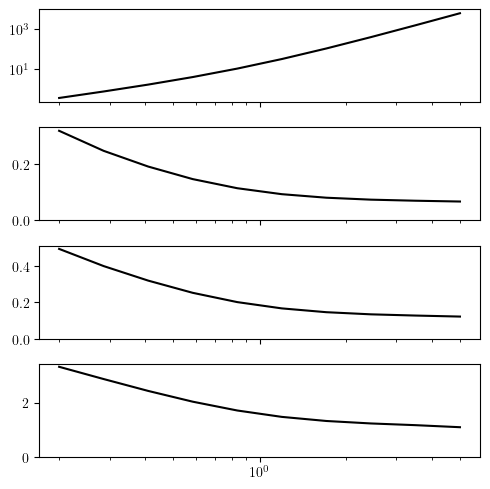

In [191]:
fig, axes = plt.subplots(4, 1, figsize=(5,5), sharex=True)

axes[0].plot(q0_list, flux2_data, 'k')
axes[1].plot(q0_list, urange_data, 'k')
axes[2].plot(q0_list, vrange_data, 'k')
axes[3].plot(q0_list, φrange_data, 'k')

for ax in axes[1:]:
    ax.set_ylim(0)

plt.xscale('log')
axes[0].set_yscale('log')

plt.tight_layout()
plt.show()

Fixed $q_0$:

In [192]:
q0 = 2
rmax = 10*q0

χ0p_list = np.linspace(0, 0.35, 5)

χinf_data = []
flux2_data = []
urange_data = []
vrange_data = []
φrange_data = []

for χ0p in χ0p_list:
    soln = wh.wormhole_T11(q0, χ0p, rmax, xatol=10**-10)
    r, f, u, ud, v, vd, φ, φd, χ, χd, h, flux2 = soln

    χinf_data.append(χ[-1])
    flux2_data.append(flux2)
    urange_data.append(max(u) - min(u))
    vrange_data.append(max(v) - min(v))
    φrange_data.append(max(φ) - min(φ))


Performing shooting method for q0 = 2 and χ0p = 0.0 out to r = 20 ...
    rmax = 2.0000 with xatol = 0.0001
        f_eval : 90
            u0 : -0.07563656183
            v0 : +0.1329819649
           val : 1.633960283e-07
    rmax = 6.3246 with xatol = 0.0001
        f_eval : 49
            u0 : -0.07755002757
            v0 : +0.1403072126
           val : 1.189931709e-07
    rmax = 20.0000 with xatol = 1e-10
        f_eval : 240
            u0 : -0.07754760004
            v0 : +0.140296358
           val : 0

Performing shooting method for q0 = 2 and χ0p = 0.0875 out to r = 20 ...
    rmax = 2.0000 with xatol = 0.0001
        f_eval : 91
            u0 : -0.07528947847
            v0 : +0.1323745657
           val : 8.174524058e-09
    rmax = 6.3246 with xatol = 0.0001
        f_eval : 47
            u0 : -0.07718886346
            v0 : +0.139565479
           val : 1.809788959e-06
    rmax = 20.0000 with xatol = 1e-10
        f_eval : 131
            u0 : -0.07718840953
         

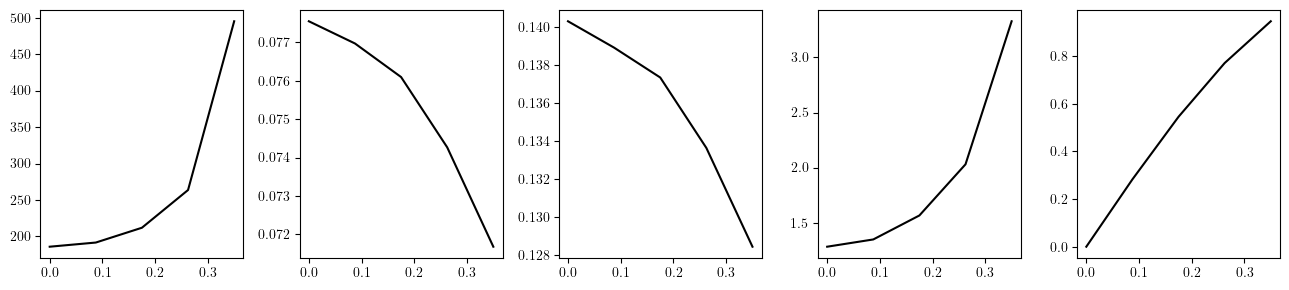

In [193]:
fig, axes = plt.subplots(1, 5, figsize=(13,3))

axes[0].plot(χ0p_list, flux2_data, 'k')
axes[1].plot(χ0p_list, urange_data, 'k')
axes[2].plot(χ0p_list, vrange_data, 'k')
axes[3].plot(χ0p_list, φrange_data, 'k')
axes[4].plot(χ0p_list, χinf_data, 'k')

plt.tight_layout()
plt.show()

In [200]:
q0s = np.geomspace(0.1, 10, 3)

q0_data = []
χinf_data = []
flux2_data = []
urange_data = []
vrange_data = []
φrange_data = []

for q0 in q0s:
    rmax = max(10, 10*q0)

    χ0p_list = np.linspace(0, 0.1, 3)

    for χ0p in χ0p_list:
        soln = wh.wormhole_T11(q0, χ0p, rmax, xatol=10**-10)
        r, f, u, ud, v, vd, φ, φd, χ, χd, h, flux2 = soln

        q0_data.append(q0)
        χinf_data.append(χ[-1])
        flux2_data.append(flux2)
        urange_data.append(max(u) - min(u))
        vrange_data.append(max(v) - min(v))
        φrange_data.append(max(φ) - min(φ))


Performing shooting method for q0 = 0.1 and χ0p = 0.0 out to r = 10 ...
    rmax = 0.1000 with xatol = 0.0001
        f_eval : 112
            u0 : -0.3745292062
            v0 : +0.4563188723
           val : 1.644733683e-09
    rmax = 1.0000 with xatol = 0.0001
        f_eval : 122
            u0 : -0.4585074144
            v0 : +0.6698583039
           val : 3.208080771e-07
    rmax = 10.0000 with xatol = 1e-10
        f_eval : 266
            u0 : -0.4585076441
            v0 : +0.6698754636
           val : 6.661338148e-16

Performing shooting method for q0 = 0.1 and χ0p = 0.05 out to r = 10 ...
    rmax = 0.1000 with xatol = 0.0001
        f_eval : 111
            u0 : -0.3745246295
            v0 : +0.4563108106
           val : 1.456880394e-09
    rmax = 1.0000 with xatol = 0.0001
        f_eval : 127
            u0 : -0.4585023379
            v0 : +0.6698310131
           val : 1.061399096e-07
    rmax = 10.0000 with xatol = 1e-10
        f_eval : 152
            u0 : -0.4585

KeyboardInterrupt: 

# OLD

Field ranges (with comparison to _ad hoc_ changes to the potential where $u,v$ are frozen or massless):

In [14]:
q0s = np.geomspace(0.01, 10, 20)

q0s_ml = np.geomspace(0.7728, q0s[-1], 100)
data_ml = np.asarray([wh.massless_approx_T11(q0) for q0 in q0s_ml])
u0s_ml, v0s_ml, φ0s_ml, f3s_ml = data_ml.T

q0s_fr = np.geomspace(q0s[0], q0s[-1], 100)
data_fr = np.asarray([wh.frozen_approx_T11(q0) for q0 in q0s_fr])
u0s_fr, v0s_fr, φ0s_fr, f3s_fr = data_fr.T

data = []

for q0 in q0s:

    rmax = max(30, 10*q0)
    soln = wh.wormhole_T11(q0, rmax, xatol=10**-10, nr=10000)
    r, w, u, ud, v, vd, φ, φd, h, f3sqr = soln

    # It happens that u<0 and v,φ>0. Extract also the 1/r^4 coefficient in φ
    #   for comparison with the BPS bound
    data.append([min(u), max(v), max(φ), np.sqrt(f3sqr), np.mean(r[-10:]**4 * φ[-10:])])

u0s, v0s, φ0s, f3s, φ4s = np.asarray(data).T


Performing shooting method for q0 = 0.01 out to r = 30 ...
    rmax = 0.0100 with xatol = 0.0001
        f_eval : 105
            u0 : -0.5541168712
            v0 : +0.5858398678
           val : 1.458690502e-09
    rmax = 0.5477 with xatol = 0.0001
        f_eval : 218
            u0 : -1.008048965
            v0 : +1.257172322
           val : 8.384649675e-08
    rmax = 30.0000 with xatol = 1e-10
        f_eval : 165
            u0 : -1.008050275
            v0 : +1.257205824
           val : 0.000168395973

Performing shooting method for q0 = 0.01438449888287663 out to r = 30 ...
    rmax = 0.0144 with xatol = 0.0001
        f_eval : 111
            u0 : -0.545160631
            v0 : +0.5794553907
           val : 6.736800007e-10
    rmax = 0.6569 with xatol = 0.0001
        f_eval : 191
            u0 : -0.9185285616
            v0 : +1.166475318
           val : 2.158910912e-07
    rmax = 30.0000 with xatol = 1e-10
        f_eval : 154
            u0 : -0.9185283122
            

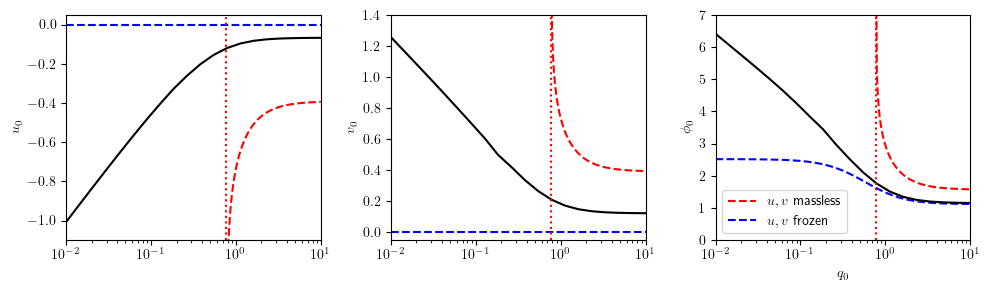

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(10,3), sharex=True)

axes[0].plot(q0s_ml, u0s_ml, '--r')
axes[0].plot(q0s_fr, u0s_fr, '--b')
axes[0].plot(q0s, u0s, 'k')

axes[1].plot(q0s_ml, v0s_ml, '--r')
axes[1].plot(q0s_fr, v0s_fr, '--b')
axes[1].plot(q0s, v0s, 'k')

axes[2].plot(q0s_ml, φ0s_ml, '--r', label='$u,v$ massless')
axes[2].plot(q0s_fr, φ0s_fr, '--b', label='$u,v$ frozen')
axes[2].plot(q0s, φ0s, 'k')

for ax, ylab in zip(axes, ['$u_0$', '$v_0$', '$\phi_0$']):
    ax.axvline(q0s_ml[0], ls=':', c='r')
    ax.set_ylabel(ylab)

plt.xlim(q0s[0], q0s[-1])
plt.xscale('log')
plt.xlabel('$q_0$')

axes[0].set_ylim(-1.1, 0.05)
axes[1].set_ylim(-0.05, 1.4)
axes[2].set_ylim(0, 7)

axes[2].legend()

plt.tight_layout()
# plt.subplots_adjust(wspace=0.25)
# plt.savefig('T11_ranges.png', dpi=300)
plt.show()

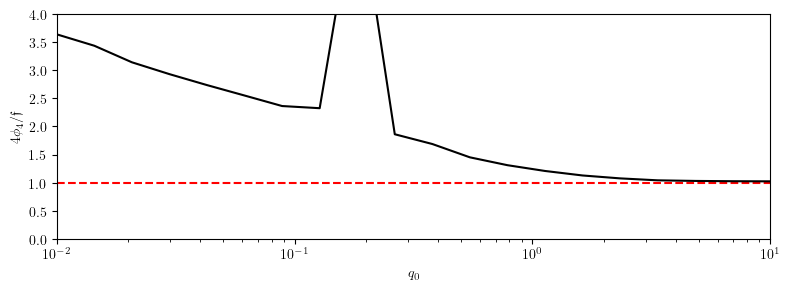

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8,3))

plt.axhline(1, ls='--', c='r')

plt.plot(q0s, 4*φ4s/f3s, 'k')

plt.xlim(q0s[0], q0s[-1])
plt.xscale('log')
plt.xlabel('$q_0$')

plt.ylim(0, 4)
plt.ylabel('$4\phi_4/\mathfrak{f}$')

plt.tight_layout()
# plt.savefig('T11_BPS.png', dpi=300)
plt.show()


Performing shooting method for q0 = 0.5 out to r = 50 ...
    rmax = 0.5000 with xatol = 0.0001
        f_eval : 106
            u0 : -0.1559952164
            v0 : +0.2465858505
           val : 1.144547424e-08
    rmax = 5.0000 with xatol = 0.0001
        f_eval : 70
            u0 : -0.1655201244
            v0 : +0.2808297174
           val : 9.706047054e-06
    rmax = 50.0000 with xatol = 1e-12
        f_eval : 327
            u0 : -0.1655181198
            v0 : +0.2808155454
           val : 0
2.341705660238049 2.3417056390787407


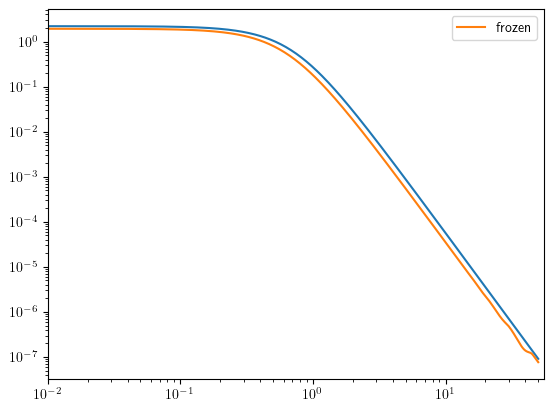

In [355]:
q0 = 0.5
q0_fr = 0.47553869
rmax = 50

soln = wh.wormhole_T11(q0, rmax, xatol=10**-12)
r, f, u, ud, v, vd, φ, φd, h, f3sqr = soln

soln_fr = wh.wormhole_frozen_T11(q0_fr, rmax)
r_fr, f_fr, u_fr, ud_fr, v_fr, vd_fr, φ_fr, φd_fr, h_fr, f3sqr_fr = soln_fr

print(f3sqr, f3sqr_fr)

plt.plot(r, φ)
plt.plot(r_fr, φ_fr, label='frozen')

plt.xlim(0.01)
# plt.ylim(10**-8, 10)
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

Flat-space limit


Performing shooting method for q0 = 1.0 out to r = 100 ...
    rmax = 1.0000 with xatol = 0.0001
        f_eval : 104
            u0 : -0.09957659666
            v0 : +0.1697326255
           val : 2.359970142e-08
    rmax = 3.1623 with xatol = 0.0001
        f_eval : 55
            u0 : -0.1030343401
            v0 : +0.1826934047
           val : 3.77686412e-07
    rmax = 10.0000 with xatol = 0.0001
        f_eval : 85
            u0 : -0.1030340309
            v0 : +0.1826984722
           val : 1.872876261e-05
    rmax = 31.6228 with xatol = 0.0001
        f_eval : 120
            u0 : -0.1030339994
            v0 : +0.1826990025
           val : 0.001073734209
    rmax = 100.0000 with xatol = 1e-12
        f_eval : 182
            u0 : -0.1030339978
            v0 : +0.1826990286
           val : 0.3504661312

Performing shooting method for q0 = 0.01 out to r = 100 ...
    rmax = 0.0100 with xatol = 0.0001
        f_eval : 105
            u0 : -0.5541168712
            v0 : +0.58

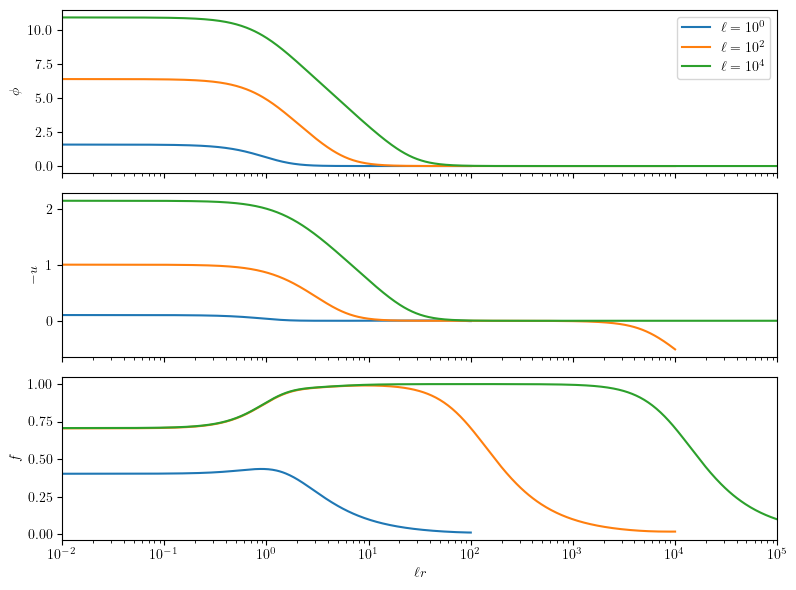

In [193]:
a0 = 1
powers = [0, 1, 2, 3, 4]

fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True)

for power in powers:
    l = 10**power
    q0 = a0 / l
    
    rmax = 100
    soln = wh.wormhole_T11(q0, rmax, xatol=10**-12, rmax_steps=5)
    r, f, u, ud, v, vd, φ, φd, h, f4sqr = soln

    q = wh.Q(r, q0)

    axes[0].plot(l*r, φ, label='$\ell=10^{}$'.format(power))
    axes[1].plot(l*r, -u)
    axes[2].plot(l*r, f)

plt.xlim(10**-2, 10**5)
plt.xscale('log')
plt.xlabel('$\ell r$')

axes[0].set_ylim(10**-8, 10**3)
axes[0].set_yscale('log')
axes[0].set_ylabel('$\phi$')
axes[0].legend()

axes[1].set_ylim(10**-8, 10**3)
axes[1].set_yscale('log')
axes[1].set_ylabel('$-u$')

axes[2].set_ylabel('$f$')

plt.tight_layout()
# plt.savefig('images/T11_flat_limit.png', dpi=300)
plt.show()